# 📌 Batch Analysis of cosmic rays using Drift Tube detectors

- Group 14: Marco Foster, Savina Tsichli

# Introduction

The Legnaro INFN Laboratories house muon detectors designed to study cosmic rays. These **mini Drift Tubes (miniDTs)** function based on **ionization**:

- Charged particles ionize the gas inside.
- Electrons drift at a constant velocity:
  
  $$
  v_{\text{drift}} = 53.8 \, \mu m/ns
  $$
  
- Signals are collected, amplified, digitized, and processed via a **Data Acquisition (DAQ) system**.
- Hits recorded by the DAQ contain time-stamped information on **muon trajectories**

# Spark

In [1]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("spark://10.67.22.87:7077") \
    .appName("Group 14") \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-common:3.3.4") \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4") \
    .config("spark.driver.host", "10.67.22.87") \
    .config("spark.dynamicAllocation.enabled", "false") \
    .config("spark.executor.cores", 4) \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.port", "6066") \
    .config("spark.executor.instances", "1") \
    .config("spark.blockManager.port", "7088") \
    .config("spark.driver.maxResultSize", "3g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider") \
    .config("spark.hadoop.fs.s3a.access.key", "4e0262c6d36a4fb4a627bbdfd4e28e8a") \
    .config("spark.hadoop.fs.s3a.secret.key", "e009cac9320e4b5cbd99e21c28ef03cd") \
    .config("spark.hadoop.fs.s3a.endpoint", "https://cloud-areapd.pd.infn.it:5210") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.metadatastore.impl", "org.apache.hadoop.fs.s3a.s3guard.NullMetadataStore") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .config("com.amazonaws.sdk.disableCertChecking", "true") \
    .getOrCreate()


## Setup

In [2]:
from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .master("spark://10.67.22.87:7077")\
    .appName("Your Spark Application Name")\
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-common:3.3.4')\
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.3.4')\
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
    .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
    .config('spark.hadoop.fs.s3a.access.key', '4e0262c6d36a4fb4a627bbdfd4e28e8a')\
    .config('spark.hadoop.fs.s3a.secret.key', 'e009cac9320e4b5cbd99e21c28ef03cd')\
    .config('spark.hadoop.fs.s3a.endpoint', 'https://cloud-areapd.pd.infn.it:5210')\
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.metadatastore.impl", "org.apache.hadoop.fs.s3a.s3guard.NullMetadataStore") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled","false") \
    .config("com.amazonaws.sdk.disableCertChecking","true") \
    .getOrCreate()

:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/qasim/.ivy2/cache
The jars for the packages stored in: /home/qasim/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ec71617f-9841-4bbd-b9f6-533c51d28314;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 322ms :: artifacts dl 6ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.12.262 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.4 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	-----------------------------------

In [3]:
sc = spark.sparkContext

In [4]:
spark

In [8]:
sc._jsc.sc().getExecutorMemoryStatus().size()

4

In [6]:
print("Driver Python:", os.environ.get("PYSPARK_DRIVER_PYTHON"))
print("Worker Python:", os.environ.get("PYSPARK_PYTHON"))

Driver Python: /home/qasim/anaconda3/envs/MAPD/bin/python
Worker Python: /home/qasim/anaconda3/envs/MAPD/bin/python


# Libraries

In [9]:
from pyspark.sql.functions import col, lit, when, collect_list
from pyspark.sql import Window
import pyspark.sql.functions as F
import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from statistics import mean
from itertools import product
from collections import defaultdict
from matplotlib.patches import Rectangle
import random

# Data Structure & Cleansing

The dataset is stored on CloudVeneto Object Storage in an **S3 bucket**.
Each hit is encoded in a **64-bit word** with the following structure:

- **Bits 0-4** → TDC: Time-to-Digital Converter output  
- **Bits 5-16** → BX: Bunch Crossing counter  
- **Bits 17-48** → ORBIT: Global orbit counter  
- **Bits 49-57** → CHAN: Detector channel  
- **Bits 58-60** → FPGA: FPGA processing unit  
- **Bits 61-63** → HEAD: Data type  

Before reconstructing events, we must remove **non-TDC hit data**.

- The **HEAD** field indicates the type of data.
- Only entries with **HEAD == 2** correspond to actual **TDC hits**.
- Other HEAD values (0,1,3,4,5) are ancillary data and must be **dropped**.

•	Orbits with a large number of hits are a tricky to handle, so we can drop the entire orbit if the number exceeds a given amount (15 for instance)


## Data Unpacking

In [10]:
def unpack(file_content):
    word_size = 8
    words = (file_content[i:i+word_size] for i in range(0,len(file_content), word_size))
    unpacked = []
    for word in words:
        word = struct.unpack('<q', word)[0]
        if (word >> 61) & 0x7 == 2: #only TDC hits
            unpacked.append([
                (word >> 58) & 0x7, #fpga
                (word >> 49) & 0x1FF, #channel
                (word >> 17) & 0xFFFFFFFF, #orbit
                (word >> 5) & 0xFFF, #bx
                (word >> 0) & 0x1F, #tdc
            ])
    return unpacked

## Data

In [11]:
s3_path = "s3a://mapd-minidt-batch/data_*.dat"
rdd = spark.sparkContext.binaryFiles(s3_path)
unpacked_rdd = rdd.flatMap(lambda file_content: unpack(file_content[1]))
df = unpacked_rdd.toDF(['FPGA', 'CHAN', 'ORBIT', 'BX', 'TDC'])

25/10/14 20:51:40 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [12]:
print(df.columns)

['FPGA', 'CHAN', 'ORBIT', 'BX', 'TDC']


# Detector Mapping

Each **TDC hit** is mapped to a specific **chamber** based on the **FPGA unit** and **channel number**:

- **Chamber 0** → FPGA = 0, CHANNEL in **[0-63]**
- **Chamber 1** → FPGA = 0, CHANNEL in **[64-127]**
- **Chamber 2** → FPGA = 1, CHANNEL in **[0-63]**
- **Chamber 3** → FPGA = 1, CHANNEL in **[64-127]**

In [13]:
df = df.withColumn('CHAMBER', when((df.FPGA==0) & (df.CHAN < 63), 0)\
                   .when((df.FPGA==0) & (df.CHAN > 63) & (df.CHAN < 128), 1)\
                   .when((df.FPGA==1) & (df.CHAN < 63), 2)\
                   .when((df.FPGA==1) & (df.CHAN > 63) & (df.CHAN < 128), 3)\
                   .when((df.FPGA==1) & (df.CHAN ==128), 4)).na.drop()

- The overall positioning of the reference frame of the four chambers, as measured from the floor of the experiment hall where the detectors are located, is the following:

In [14]:
#shift of the reference frame of each chamber (x,y,z)
shift_chamber = {
    0: {'x': 0, 'y': 0, 'z': 219.8}, #Ch 0
    1: {'x': 0, 'y': 0, 'z': 977.3}, #Ch 1
    2: {'x': 0, 'y': 0, 'z': 1035.6}, #Ch 2 
    3: {'x': 0, 'y': 0, 'z': 1819.8}, #Ch 3
}

In [15]:
df = df.withColumn('shift_z', when(col('CHAMBER') == 0, shift_chamber[0]['z'])
                   .when(col('CHAMBER') == 1, shift_chamber[1]['z'])
                   .when(col('CHAMBER') == 2, shift_chamber[2]['z'])
                   .when(col('CHAMBER') == 3, shift_chamber[3]['z'])
                   .otherwise(None))

- Within each chamber the channel numbering follows a specific recurrent pattern

## Channel Pattern

In [16]:
def channel_pattern():
    rows, cols = 4, 16  # 4 rows, 16 columns
    width, height = 42, 13  # mm
    stagger_offset = width / 2  # Offset for staggered rows
    
    chamber = []  # Store cell information
    numbering = np.zeros((rows, cols), dtype=int)
    
    for col in range(cols):
        numbering[0, col] = col * 4
        numbering[1, col] = col * 4 + 2
        numbering[2, col] = col * 4 + 1
        numbering[3, col] = col * 4 + 3
    
    fig, ax = plt.subplots(figsize=(12, 4))
    
    for row in range(rows):
        for col in range(cols):
            x = col * width + (stagger_offset if row % 2 == 1 else 0)
            y = -row * height  # Negative y for proper layout
            
            chamber.append({
                'channel': numbering[row, col],
                'x': x,
                'y': y
            })
            
            rect = plt.Rectangle((x, y), width, height, fill=False, edgecolor='black')
            ax.add_patch(rect)
            ax.text(x + width/2, y + height/2, str(numbering[row, col]), 
                    ha='center', va='center', fontsize=8)
    
    ax.set_xlim(-10, cols * width + 10)
    ax.set_ylim(-rows * height - 10, 10)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.title("Drift Tube Chamber Layout")
    plt.show()
    
    return chamber

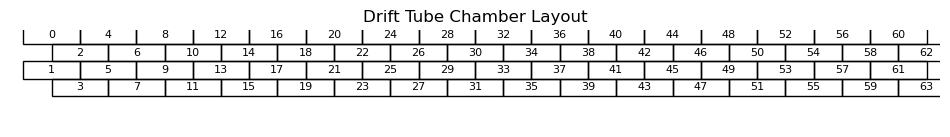

[{'channel': 0, 'x': 0, 'y': 0},
 {'channel': 4, 'x': 42, 'y': 0},
 {'channel': 8, 'x': 84, 'y': 0},
 {'channel': 12, 'x': 126, 'y': 0},
 {'channel': 16, 'x': 168, 'y': 0},
 {'channel': 20, 'x': 210, 'y': 0},
 {'channel': 24, 'x': 252, 'y': 0},
 {'channel': 28, 'x': 294, 'y': 0},
 {'channel': 32, 'x': 336, 'y': 0},
 {'channel': 36, 'x': 378, 'y': 0},
 {'channel': 40, 'x': 420, 'y': 0},
 {'channel': 44, 'x': 462, 'y': 0},
 {'channel': 48, 'x': 504, 'y': 0},
 {'channel': 52, 'x': 546, 'y': 0},
 {'channel': 56, 'x': 588, 'y': 0},
 {'channel': 60, 'x': 630, 'y': 0},
 {'channel': 2, 'x': 21.0, 'y': -13},
 {'channel': 6, 'x': 63.0, 'y': -13},
 {'channel': 10, 'x': 105.0, 'y': -13},
 {'channel': 14, 'x': 147.0, 'y': -13},
 {'channel': 18, 'x': 189.0, 'y': -13},
 {'channel': 22, 'x': 231.0, 'y': -13},
 {'channel': 26, 'x': 273.0, 'y': -13},
 {'channel': 30, 'x': 315.0, 'y': -13},
 {'channel': 34, 'x': 357.0, 'y': -13},
 {'channel': 38, 'x': 399.0, 'y': -13},
 {'channel': 42, 'x': 441.0, 'y': -

In [17]:
channel_pattern()

# Hit Time Information

The **TDC time information** for each signal is provided using **three counters**, simulating the **LHC clock distribution**:

- **1 ORBIT** = **3564 BX**
- **1 BX** = **25 ns**
- **1 TDC** = **1/30 BX**

- Computing **Absolute Time**
Each **hit time** is calculated using the formula:

$$
t_{\text{TDC hit}} (\text{ns}) = 25 \times (\text{ORBIT} \times 3564 + \text{BX} + \frac{\text{TDC}}{30})
$$

- **Muon Passage Time ($t_0$)**
The **$t_0$** signal is provided by an external scintillator, which is encoded in **TDC hits** where:

- **(FPGA == 1) AND (CHANNEL == 128)**

- **Time Correction for $t_0$**
Due to **signal transmission delays**, the **scintillator $t_0$** is delayed by **~95 ns** compared to chamber hits.

### **Fine-Tuning for Each Chamber**

In [18]:
# scintillator time offset by chamber
timecorrections = {
    0: 95.0 - 1.1, #Ch 0
    1: 95.0 + 6.4, #Ch 1
    2: 95.0 + 0.5, #Ch 2
    3: 95.0 - 2.6, #Ch 3
}

- The overall positioning of the reference frame of the four chambers, as measured from the floor of the experiment hall where the detectors are located, is the following:

In [19]:
# Calculate ABSOLUTETIME
df = df.withColumn(
    'ABSOLUTETIME',
    25 * (col('ORBIT') * 3564 + col('BX') + col('TDC') / 30)
)

# Apply time corrections based on FPGA and CHAMBER
df = df.withColumn(
    'T_HIT_ns',
    col('ABSOLUTETIME') + when(col('CHAMBER') == 0, timecorrections[0])
                           .when(col('CHAMBER') == 1, timecorrections[1])
                           .when(col('CHAMBER') == 2, timecorrections[2])
                           .when(col('CHAMBER') == 3, timecorrections[3])
                           .otherwise(0)
)

In [20]:
print(df.columns)

['FPGA', 'CHAN', 'ORBIT', 'BX', 'TDC', 'CHAMBER', 'shift_z', 'ABSOLUTETIME', 'T_HIT_ns']


# Track Reconstruction

To **reconstruct the muon trajectory** inside the detector, a pre-selection must be performed:

- Hits must be grouped based on the **ORBIT** counter.

- Selecting **Valid Hits**
-- Only hits with a corresponding **scintillator signal** in the same orbit should be retained.

- Converting Hit Time to Spatial Coordinates
-- Each hit is positioned in the detector geometry by converting **hit time** into **spatial coordinates** using the drift velocity:

  $$
  v_{\text{drift}} = 53.8 \, \mu m/ns
  $$

- At this stage, the **left-right ambiguity** remains **unresolved**, so each hit must be assigned **two possible X positions**:

  - **XLEFT** (assuming drift to the left)
  - **XRIGHT** (assuming drift to the right)

---

- With the preprocessed dataset, we can estimate the **muon trajectory**.

## Scintillator Hits

In [21]:
#scintillator hits, determines the start time of muon through detector
scintillator_hits = df.filter((col("CHAMBER") == 4)) \
                      .select("ORBIT", "T_HIT_ns") \
                      .withColumnRenamed("T_HIT_ns", "t0")

scintillator_counts = scintillator_hits.groupBy("ORBIT").count() \
                                       .withColumnRenamed("count", "hit_count") 

In [22]:
#dfnew: joining scintillator hits
dfnew = df.join(scintillator_hits, on="ORBIT", how="inner")

In [23]:
# Compute hit counts
hit_counts = dfnew.groupBy("ORBIT", "CHAMBER").count()
total_hits_per_orbit = dfnew.groupBy("ORBIT").count().withColumnRenamed("count", "total_hits")

# Filter ORBITs with hits in CHAMBERs 0, 2, and 3
orbits_with_ch0 = hit_counts.filter(F.col("CHAMBER") == 0).select("ORBIT").distinct()
orbits_with_ch2 = hit_counts.filter(F.col("CHAMBER") == 2).select("ORBIT").distinct()
orbits_with_ch3 = hit_counts.filter(F.col("CHAMBER") == 3).select("ORBIT").distinct()

valid_orbits = orbits_with_ch0.intersect(orbits_with_ch2).intersect(orbits_with_ch3)

# Filter ORBITs with < 15 hits
valid_orbits_with_hits = valid_orbits.join(total_hits_per_orbit, "ORBIT") \
                                     .filter(F.col("total_hits") < 15) \
                                     .select("ORBIT")

#all columns from valid_orbits_with_hits
df_filtered_with_hits = dfnew.join(valid_orbits_with_hits, "ORBIT", how="inner")

#filter keeping only oarbit
df_filtered = dfnew.join(valid_orbits_with_hits.select("ORBIT"), on="ORBIT", how="inner")


In [24]:
print(df_filtered.columns)

['ORBIT', 'FPGA', 'CHAN', 'BX', 'TDC', 'CHAMBER', 'shift_z', 'ABSOLUTETIME', 'T_HIT_ns', 't0']


## Hit time to spatial coordinates

In [25]:
# Calculate x positions and handle ambiguity
width = 42  # mm
height = 13  # mm
v_drift = 53.8 # μm

## Coordinates values for Track Reconstruction 

In [26]:
# X_HIT
dfnew = df_filtered.withColumn(
        "X_HIT",
        (F.col("T_HIT_ns") - F.col("t0")) * (F.lit(v_drift) / 1000) # Convert um to mm, remove negative values
    )

dfnew = dfnew.filter(F.col("X_HIT").isNotNull()) #removing rows where X_HIT is null

# x-centre of each channel
dfnew = dfnew.withColumn(
    'X_CENTRE',
    when(
        ((col('CHAMBER').isin(0, 2)) & (col('CHAN') % 4).isin(0, 1)),
        42 * F.floor(col('CHAN') / 4) + 21
    )
    .when(
        ((col('CHAMBER').isin(0, 2)) & (col('CHAN') % 4).isin(2, 3)),
        42 * F.floor(col('CHAN') / 4) + 42
    )
    .when(
        ((col('CHAMBER').isin(1, 3)) & (col('CHAN') % 4).isin(0, 1)),
        42 * F.floor((col('CHAN') - 64) / 4) + 21
    )
    .when(
        ((col('CHAMBER').isin(1, 3)) & (col('CHAN') % 4).isin(2, 3)),
        42 * F.floor((col('CHAN') - 64) / 4) + 42
    )
)

# X_LEFT and X_RIGHT based on X_CENTRE
dfnew = dfnew.withColumn('X_LEFT', col('X_CENTRE') - col('X_HIT'))
dfnew = dfnew.withColumn('X_RIGHT', col('X_CENTRE') + col('X_HIT'))

# Adding Z coordinates for each channel in the local track
dfnew = dfnew.withColumn(
    'Z_LOCAL',
    when((col('CHAN') % 4 == 0), 19.5)
    .when((col('CHAN') % 4 == 1), -6.5)
    .when((col('CHAN') % 4 == 2), 6.5)
    .when((col('CHAN') % 4 == 3), -19.5)
)

dfnew = dfnew.withColumn(
    'Z_GLOBAL',
    col('Z_LOCAL') + col('shift_z')
)

print(dfnew)

DataFrame[ORBIT: bigint, FPGA: bigint, CHAN: bigint, BX: bigint, TDC: bigint, CHAMBER: int, shift_z: double, ABSOLUTETIME: double, T_HIT_ns: double, t0: double, X_HIT: double, X_CENTRE: bigint, X_LEFT: double, X_RIGHT: double, Z_LOCAL: double, Z_GLOBAL: double]


# Plotting 

## Plotting the Best Fit

In [27]:
from itertools import product
import numpy as np

def best_fit_rdd(points):
    """
    Takes a list of (X_LEFT, X_RIGHT, Z_LOCAL) and computes the best line fit
    using both X_LEFT and X_RIGHT combinations.
    Returns (m, b, residuals) or None if insufficient data.
    """
    points = list(points)
    if not points or len(points) < 2:
        return None

    x_lefts = [p[0] for p in points]
    x_rights = [p[1] for p in points]
    z_vals = np.array([p[2] for p in points])

    # All possible combinations of left/right for each point
    try:
        combinations = list(product(*zip(x_lefts, x_rights)))
    except Exception:
        return None

    best_m, best_b = None, None
    min_residuals = float("inf")

    for combo in combinations:
        x_vals = np.array(combo)
        A = np.vstack([x_vals, np.ones(len(x_vals))]).T
        m, b = np.linalg.lstsq(A, z_vals, rcond=None)[0]
        residuals = np.linalg.norm(z_vals - (m * x_vals + b))

        if residuals < min_residuals:
            min_residuals = residuals
            best_m, best_b = m, b
            combin = combo

    return (best_m, best_b, min_residuals, combin)

## Remove Outliers

In [28]:
def remove_outliers_b(xs: list, threshold: float = 4*42, k: int = 2):
    xs = np.array(xs, dtype=float) # x coordinates
    differences = np.abs(xs[:, None] - xs) # compute pairwise distances
    
    # count how many distances exceed the threshold for each point
    count_exceeding = np.sum(differences > threshold, axis=1)
    
    # Return False for outliers (when k or more distances exceed the threshold)
    return count_exceeding < k

In [29]:
# Select only valid rows
df_ch = (
    dfnew
    .select("ORBIT", "CHAMBER", "X_LEFT", "X_RIGHT", "Z_GLOBAL")
    .filter("X_LEFT IS NOT NULL AND X_RIGHT IS NOT NULL AND Z_GLOBAL IS NOT NULL")
)

# Convert to RDD with key = (ORBIT, CHAMBER)
first_rdd = df_ch.rdd.map(lambda row: (
    (row["ORBIT"], row["CHAMBER"]),
    [row["X_LEFT"], row["X_RIGHT"], row["Z_GLOBAL"]]
))

# Group hits belonging to the same orbit and chamber
grouped_rdd = first_rdd.combineByKey(
    lambda x: [[x[0]], [x[1]], [x[2]]],  # create initial lists
    lambda acc, x: [acc[0] + [x[0]], acc[1] + [x[1]], acc[2] + [x[2]]],  # merge within partition
    lambda acc1, acc2: [acc1[0] + acc2[0], acc1[1] + acc2[1], acc1[2] + acc2[2]]  # merge across partitions
)

# Apply best fit line computation (no outlier filtering)
rdd = grouped_rdd.map(lambda kv: (
    (kv[0][1], kv[0][0]),  # key = (CHAMBER, ORBIT)
    (
        [kv[1][0], kv[1][1], kv[1][2]],  # full hit lists
        best_fit_rdd(zip(kv[1][0], kv[1][1], kv[1][2]))  # compute fit params
    )
))

# Keep only orbits with 3+ hits
rdd = rdd.filter(lambda x: len(x[1][0][0]) > 2)

In [30]:
def draw_chambers(ax, shift_chamber):
    """Draw all four chambers using their z-axis (y-axis in plot) offsets."""
    cell_shift = 2 * 13

    for ch_id, shift in shift_chamber.items():
        z_offset = shift['z'] - cell_shift  # Shift everything up by two cells
        
        # Horizontal boundaries (top and bottom of chamber)
        ax.hlines(z_offset + 0, xmin=21, xmax=693, color='grey', linestyle='dashed')
        ax.hlines(z_offset + 52, xmin=0, xmax=672, color='grey', linestyle='dashed')
        
        # Internal horizontal lines (dividing rows)
        for i in range(1, 4):
            ax.hlines(z_offset + 13*i, xmin=0, xmax=693, color='grey', linestyle='dashed')
        
        # Vertical boundaries (channels)
        for j in range(17):
            ax.vlines(x=42*j, ymin=z_offset + 13, ymax=z_offset + 26, color='grey', linestyle='dashed')
            ax.vlines(x=42*j, ymin=z_offset + 39, ymax=z_offset + 52, color='grey', linestyle='dashed')
            ax.vlines(x=21+42*j, ymin=z_offset + 0, ymax=z_offset + 13, color='grey', linestyle='dashed')
            ax.vlines(x=21+42*j, ymin=z_offset + 26, ymax=z_offset + 39, color='grey', linestyle='dashed')

In [31]:
#plots the x's against z with best fit
def plot_local(x_left, x_right, x_centre, z_values, m, b, orbit, chamber):

    fig, ax = plt.subplots(figsize=(10, 6))

    plt.scatter(x_centre, z_values, color="blue", label="X_CENTRE", marker="o")
    plt.scatter(x_left, z_values, color="red", label="X_LEFT", marker="x")
    plt.scatter(x_right, z_values, color="green", label="X_RIGHT", marker="x")

    ax.hlines(0, xmin=21, xmax=693, color='grey', linestyle='dashed')
    ax.hlines(52, xmin=0, xmax=672, color='grey', linestyle='dashed')

    draw_chambers(ax, shift_chamber)

    Z_fit = np.linspace(min(z_values), max(z_values), 1000)
    X_fit = (Z_fit - b) / m

    plt.plot(X_fit, Z_fit, '--', color="black", linewidth=1.2, label="Best Fit Line")
    plt.xlabel("X [µm]")
    plt.ylabel("Z [µm]")
    plt.title(f"Local Fit for Orbit {orbit}, Chamber {chamber}")
    
    x_min = min(min(X_fit), min(x_left))
    x_max = max(max(X_fit), max(x_right))
    ax.set_xlim(x_min - 10, x_max + 10)

    z_min = min(z_values)
    z_max = max(z_values)
    ax.set_ylim(z_min - 42, z_max + 42)
    
    plt.legend()
    plt.grid()
    plt.show()

Plotting Orbit 58581946, Chamber 3 | Slope: -0.000, Intercept: 1826.300


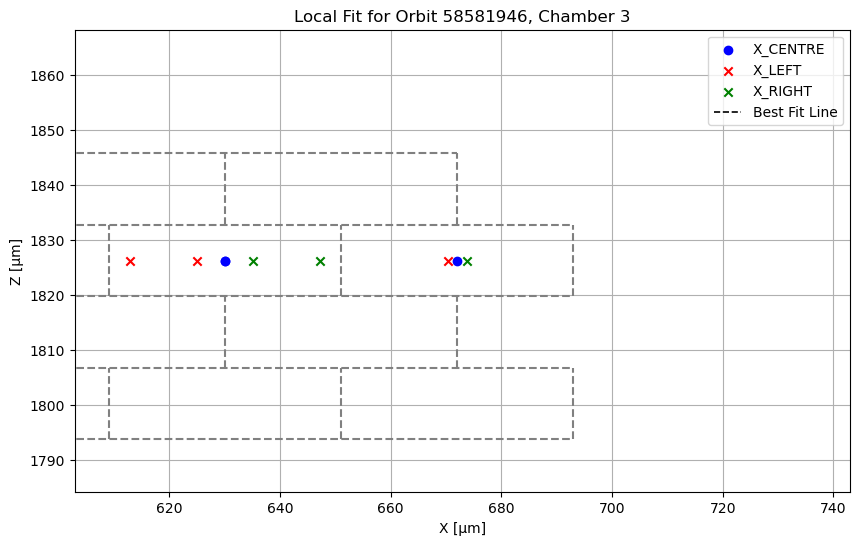

Plotting Orbit 211001721, Chamber 3 | Slope: 0.329, Intercept: 1618.941


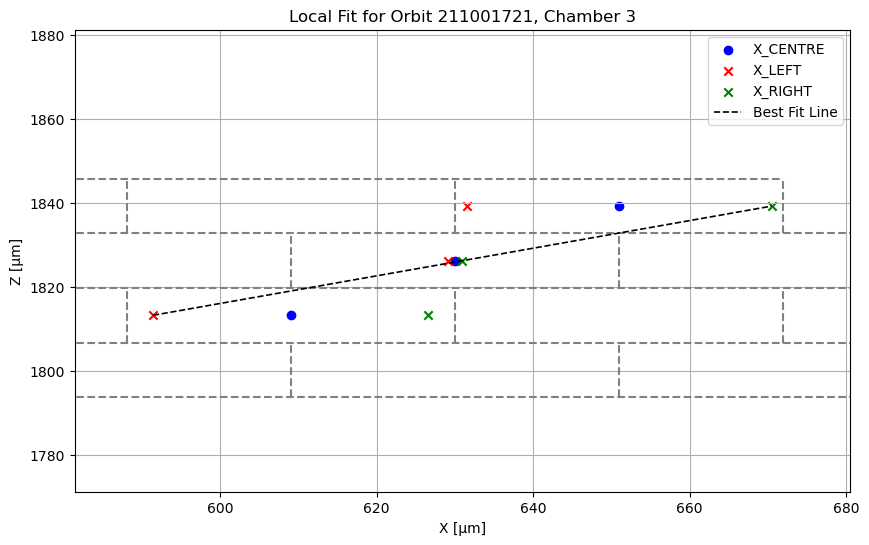

Plotting Orbit 109832794, Chamber 3 | Slope: 3.653, Intercept: -631.125


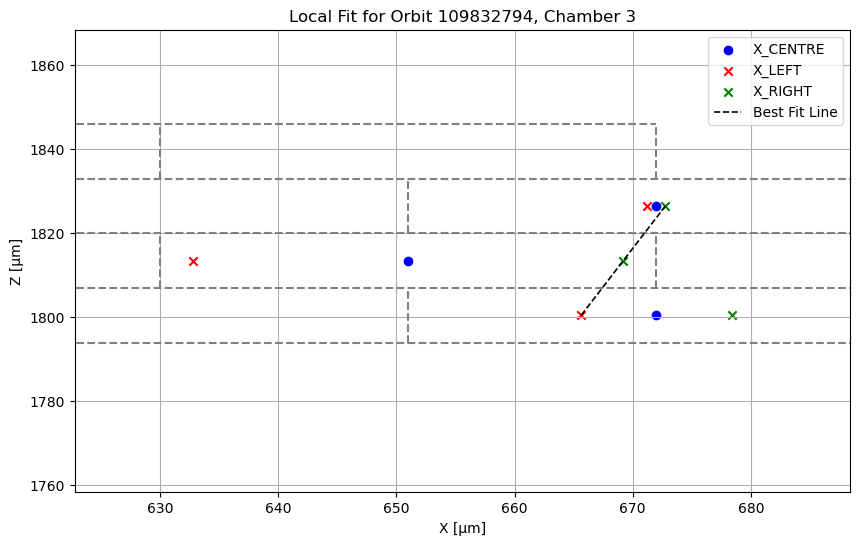

Plotting Orbit 13726588, Chamber 3 | Slope: 4.435, Intercept: -1051.076


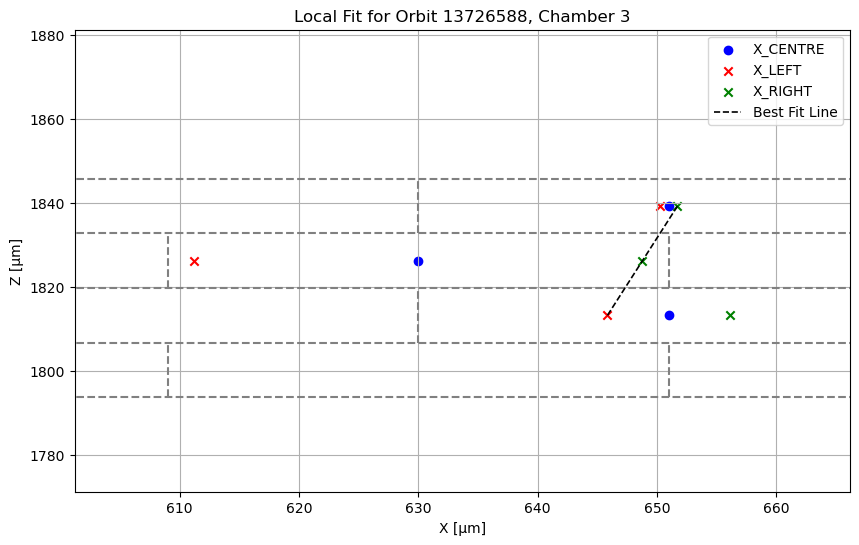

Plotting Orbit 81707535, Chamber 0 | Slope: -0.347, Intercept: 415.218


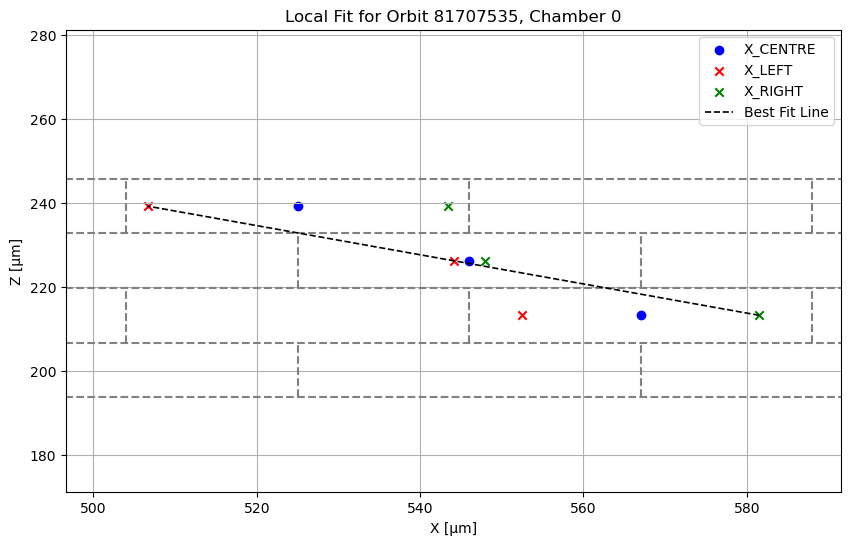

In [32]:
valid = rdd.filter(lambda kv: kv[1][1] is not None)
sorted_fits = valid.collect()
sorted_fits.sort(key=lambda kv: kv[1][1][2])
best_fits = sorted_fits[:5]

for (chamber, orbit), (value_lists, fit_params) in best_fits:
    x_lefts, x_rights, z_vals = value_lists
    m, b, _, __ = fit_params
    x_centres = [(xl + xr) / 2 for xl, xr in zip(x_lefts, x_rights)]

    print(f"Plotting Orbit {orbit}, Chamber {chamber} | Slope: {m:.3f}, Intercept: {b:.3f}")
    plot_local(x_lefts, x_rights, x_centres, z_vals, m, b, orbit, chamber)

## Worst Fits

Plotting Orbit 42308718, Chamber 0 | Slope: -0.329, Intercept: 321.784


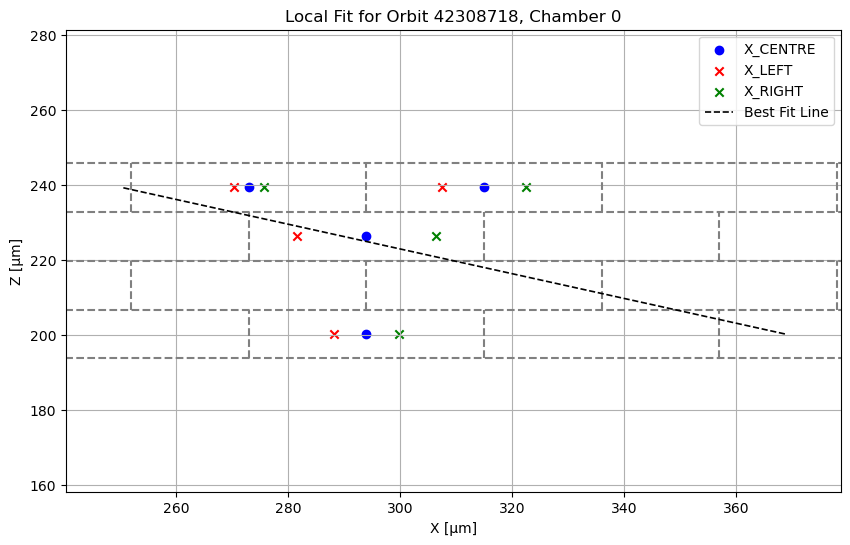

Plotting Orbit 359036646, Chamber 1 | Slope: -0.689, Intercept: 1426.725


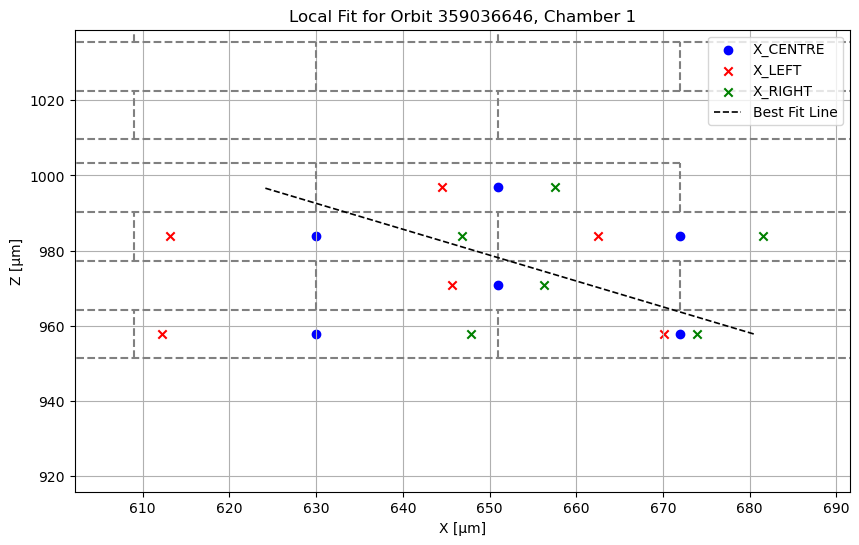

Plotting Orbit 261805240, Chamber 2 | Slope: 0.048, Intercept: 1022.624


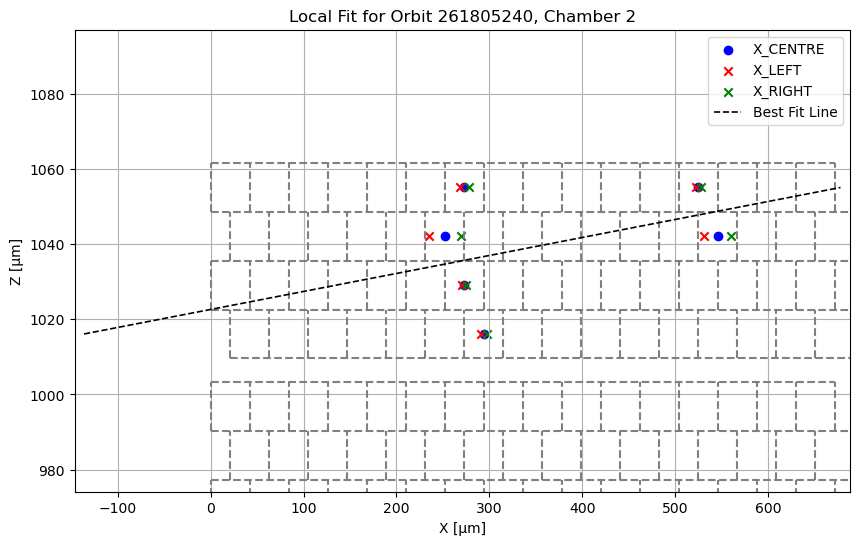

Plotting Orbit 32590449, Chamber 1 | Slope: 0.016, Intercept: 969.094


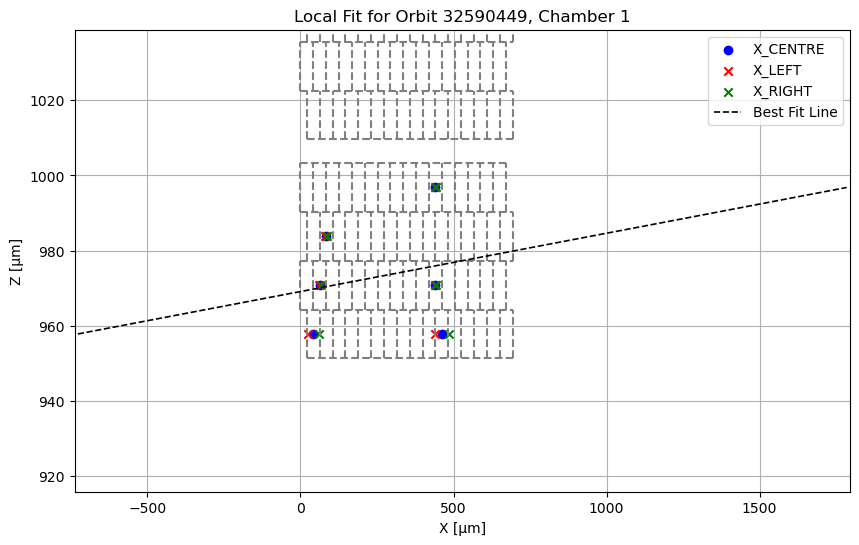

Plotting Orbit 180586786, Chamber 1 | Slope: 0.121, Intercept: 912.098


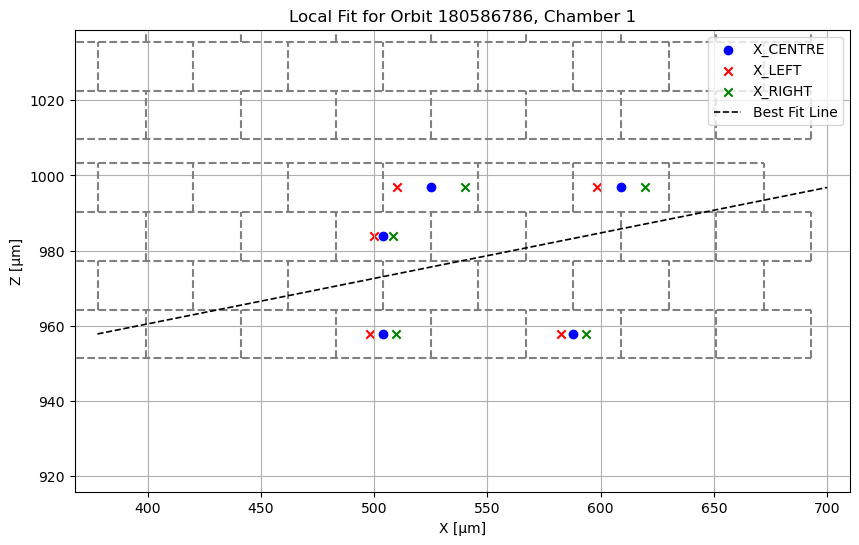

In [33]:
# Now determining the WORST fits
worst_fits = sorted_fits[-5:]

for (chamber, orbit), (value_lists, fit_params) in worst_fits:
    x_lefts, x_rights, z_vals = value_lists
    m, b, _, __ = fit_params
    x_centres = [(xl + xr) / 2 for xl, xr in zip(x_lefts, x_rights)]

    print(f"Plotting Orbit {orbit}, Chamber {chamber} | Slope: {m:.3f}, Intercept: {b:.3f}")
    plot_local(x_lefts, x_rights, x_centres, z_vals, m, b, orbit, chamber)

## Reduced Chi-Squared

In [34]:
# uncairtenty
SIGMA = 21

def compute_reduced_chi2(x_lefts, x_rights, z_vals, fit_params, sigma=SIGMA):
    """
    Compute reduced chi-squared of the best-fit line for one orbit.
    """
    if fit_params is None or len(x_lefts) < 3:
        return None

    m, b, *_ = fit_params
    x_centres = np.array([(xl + xr) / 2 for xl, xr in zip(x_lefts, x_rights)])
    z_vals = np.array(z_vals)

    # predicted x from bestfit line
    x_pred = m * z_vals + b
    residuals = x_centres - x_pred

    chi2 = np.sum((residuals / sigma) ** 2)
    dof = len(z_vals) - 2  # slope and intercept fitted
    if dof <= 0:
        return None
    return chi2 / dof

In [35]:
# Compute (CHAMBER, ORBIT, reduced_chi2)
chi2_rdd = rdd.map(lambda kv: (
    kv[0][1],  # ORBIT
    compute_reduced_chi2(kv[1][0][0], kv[1][0][1], kv[1][0][2], kv[1][1])
)).filter(lambda x: x[1] is not None)

# Collect all reduced chi² values
chi2_values = [val for _, val in chi2_rdd.collect()]

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1347052/1343803982.py:3: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel("Reduced $\chi^2$")
/tmp/ipykernel_1347052/1343803982.py:5: SyntaxWarning: invalid escape sequence '\c'
  plt.title("Distribution of Reduced $\chi^2$ Values (Before Outlier Removal)")


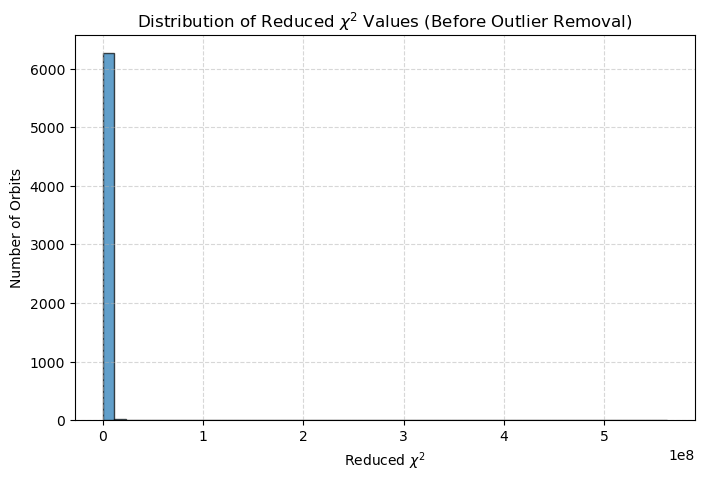

In [36]:
plt.figure(figsize=(8, 5))
plt.hist(chi2_values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Reduced $\chi^2$")
plt.ylabel("Number of Orbits")
plt.title("Distribution of Reduced $\chi^2$ Values (Before Outlier Removal)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [37]:
chi2_mean = np.mean(chi2_values)
chi2_std = np.std(chi2_values)
chi2_max = np.max(chi2_values)
chi2_min = np.min(chi2_values)
chi2_p25 = np.percentile(chi2_values, 25)
chi2_p50 = np.percentile(chi2_values, 50)  # median
chi2_p75 = np.percentile(chi2_values, 75)
chi2_p90 = np.percentile(chi2_values, 90)
chi2_p99 = np.percentile(chi2_values, 99)

# Print statistics neatly
print("Reduced χ² Summary Statistics:")
print(f"Count: {len(chi2_values)}")
print(f"Mean: {chi2_mean:.3f}")
print(f"Std Dev: {chi2_std:.3f}")
print(f"Min: {chi2_min:.3f}")
print(f"25th percentile: {chi2_p25:.3f}")
print(f"Median (50th): {chi2_p50:.3f}")
print(f"75th percentile: {chi2_p75:.3f}")
print(f"90th percentile: {chi2_p90:.3f}")
print(f"99th percentile: {chi2_p99:.3f}")
print(f"Max: {chi2_max:.3f}")


📊 Reduced χ² Summary Statistics:
Count: 6284
Mean: 350067.491
Std Dev: 7642846.819
Min: 0.784
25th percentile: 2677.358
Median (50th): 16677.536
75th percentile: 64568.788
90th percentile: 278252.698
99th percentile: 3280534.788
Max: 562351139.623


In [50]:
def remove_angle_outliers(rdd, max_angle_deg=20):
    """
    Removes orbits where the best-fit line is too skewed (angle > max_angle_deg).
    """
    def within_angle_limit(kv):
        fit = kv[1][1]  # (m, b, residuals, ...)
        if fit is None:
            return False
        m = fit[0]
        if m is None:
            return False
        angle_deg = np.degrees(np.arctan(m))
        return abs(angle_deg) <= max_angle_deg

    return rdd.filter(within_angle_limit)

In [60]:
rdd_filtered_angle = remove_angle_outliers(rdd, max_angle_deg=37)

In [61]:
chi2_rdd_angle = rdd_filtered_angle.map(lambda kv: (
    kv[0][1],  # ORBIT
    compute_reduced_chi2(kv[1][0][0], kv[1][0][1], kv[1][0][2], kv[1][1])
)).filter(lambda x: x[1] is not None)

chi2_values_angle = [val for _, val in chi2_rdd_angle.collect()]

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1347052/939290983.py:3: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel("Reduced $\chi^2$")
/tmp/ipykernel_1347052/939290983.py:5: SyntaxWarning: invalid escape sequence '\c'
  plt.title("Reduced $\chi^2$ (After Angle-Based Outlier Removal)")


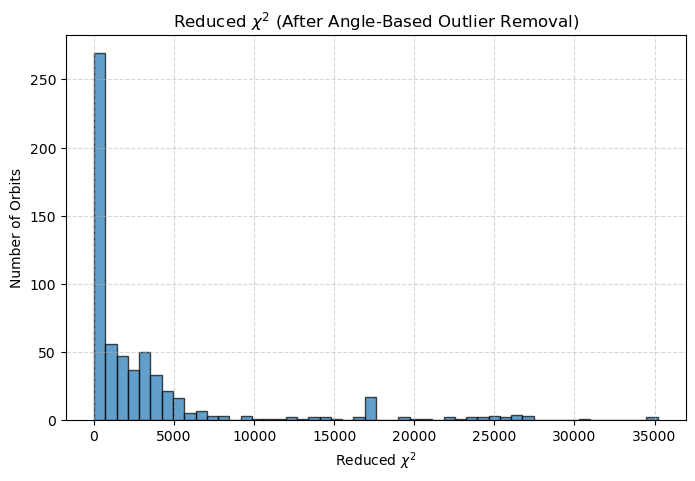

Mean: 3340.192
Max: 35199.347
Std Dev: 5907.412
5th percentile: 36.044
25th percentile: 138.773
50th percentile: 1121.048
75th percentile: 3491.895
95th percentile: 17305.176


In [62]:
plt.figure(figsize=(8,5))
plt.hist(chi2_values_angle, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Reduced $\chi^2$")
plt.ylabel("Number of Orbits")
plt.title("Reduced $\chi^2$ (After Angle-Based Outlier Removal)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Statistics
chi2_array = np.array(chi2_values_angle)
print(f"Mean: {np.mean(chi2_array):.3f}")
print(f"Max: {np.max(chi2_array):.3f}")
print(f"Std Dev: {np.std(chi2_array):.3f}")
for p in [5, 25, 50, 75, 95]:
    print(f"{p}th percentile: {np.percentile(chi2_array, p):.3f}")

# Global Fit

In [46]:
global_fit_rdd = rdd.filter(lambda x: x[0][0] in [0, 2, 3])

global_fit_rdd = global_fit_rdd.map(lambda x: (
    x[0][1],  # ORBIT is the key
    list(zip(x[1][1][3], x[1][0][2]))  # (X_hit, Z) tuples from x_hits_used and Z_GLOBALs
))
global_fit_rdd = global_fit_rdd.reduceByKey(lambda a, b: a + b)

global_fit_rdd = global_fit_rdd.filter(lambda x: len(x[1]) >= 3)

def linear_fit(points):
    X = [p[0] for p in points]
    Z = [p[1] for p in points]
    m, b = np.polyfit(X, Z, 1)
    return m, b, X, Z

global_rdd = global_fit_rdd.mapValues(linear_fit)

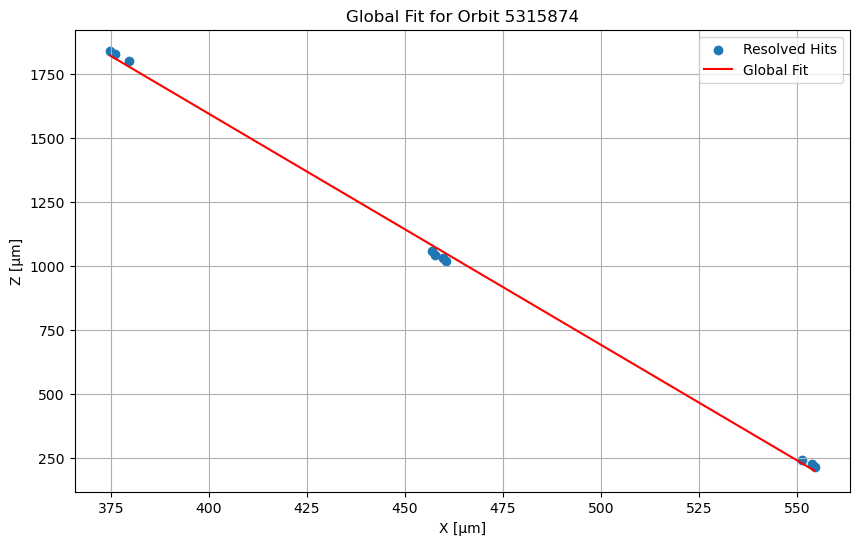

In [47]:
Orb = 5315874
data = global_rdd.filter(lambda x: x[0] == Orb).collect()

if data:
    m, b, X, Z = data[0][1]

    plt.figure(figsize=(10, 6))
    plt.scatter(X, Z, label="Resolved Hits")
    X_fit = np.linspace(min(X), max(X), 100)
    Z_fit = m * X_fit + b
    plt.plot(X_fit, Z_fit, label="Global Fit", color="red")
    plt.xlabel("X [µm]")
    plt.ylabel("Z [µm]")
    plt.title(f"Global Fit for Orbit {Orb}")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Orbit not found")

# Angular Resolution

In [48]:
from math import atan

ml_rdd = rdd.filter(lambda x: x[0][0] == 2) \
                      .map(lambda x: (x[0][1], x[1][1][0]))

mg_rdd = global_rdd.mapValues(lambda x: x[0])
slopes_rdd = ml_rdd.join(mg_rdd)
theta_rdd = slopes_rdd.mapValues(lambda pair: atan((pair[1] - pair[0]) / (1 + pair[1] * pair[0])))

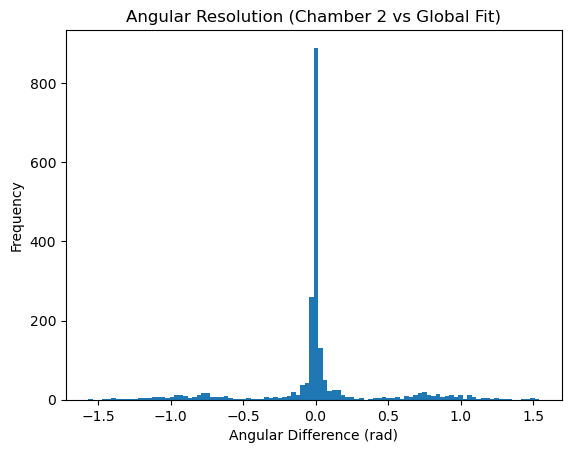

In [49]:
theta_values = theta_rdd.values().collect()

plt.hist(theta_values, bins=100)
plt.xlabel("Angular Difference (rad)")
plt.ylabel("Frequency")
plt.title("Angular Resolution (Chamber 2 vs Global Fit)")
plt.show()